# SafeScan-YOLO: PPE Detection with YOLO11n on SH17 Dataset

This notebook builds a high-performance PPE detection system using the SH17 dataset and YOLO11n, optimized for dual NVIDIA Tesla T4 GPUs. The SH17 dataset contains ~8,099 images with annotations for 17 PPE classes (e.g., Helmet, Safety Vest). The process is broken into clear steps:
1. Data Collection
2. Environment Setup
3. Data Preprocessing and Augmentation
4. Exploratory Data Analysis
5. YOLO Dataset Preparation
6. Model Training
7. Evaluation and Visualization

The goal is a robust, efficient model for real-world PPE compliance monitoring, trained in ~7-8 hours with professional-grade output.

## Step 1: Data Collection

In this step, we load the SH17 dataset from `/kaggle/input/sh17-dataset-for-ppe-detection`, which includes `images/` and `labels/` folders. We pair each image (e.g., `pexels-photo-1000.jpeg`) with its label file (e.g., `pexels-photo-1000.txt`) and filter out images without valid PPE annotations (class IDs 0–16) to ensure a high-quality dataset for YOLOv11 training.

In [2]:
import os
import shutil

# Define base directory
data_dir = './archive'
image_dir = os.path.join(data_dir, 'images')
label_dir = os.path.join(data_dir, 'labels')
print("Dataset contents:", os.listdir(data_dir))

# Load and pair images/labels
images = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
labels = [os.path.join(label_dir, lbl) for lbl in os.listdir(label_dir) if lbl.endswith('.txt')]
images.sort()
labels.sort()

image_names = [os.path.splitext(os.path.basename(img))[0] for img in images]
label_names = [os.path.splitext(os.path.basename(lbl))[0] for lbl in labels]
paired_images = [img for img, img_name in zip(images, image_names) if img_name in label_names]
paired_labels = [os.path.join(label_dir, f"{img_name}.txt") for img_name in image_names if img_name in label_names]
print(f"Paired: {len(paired_images)} images, {len(paired_labels)} labels")

# Filter valid PPE annotations
ppe_class_ids = set(range(17))
filtered_images = []
filtered_labels = []
for img_path, lbl_path in zip(paired_images, paired_labels):
    with open(lbl_path, 'r') as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]
        bboxes = [line.split() for line in lines]
        valid_bboxes = [box for box in bboxes if len(box) >= 5]
        if valid_bboxes and any(int(box[0]) in ppe_class_ids for box in valid_bboxes):
            filtered_images.append(img_path)
            filtered_labels.append(lbl_path)

print(f"Filtered: {len(filtered_images)} images, {len(filtered_labels)} labels")

Dataset contents: ['images', 'labels', 'meta-data', 'train_files.txt', 'val_files.txt', 'voc_labels']
Paired: 8099 images, 8099 labels
Filtered: 8099 images, 8099 labels


## Step 2: Environment Setup

We install necessary libraries and verify the dual T4 GPU setup for optimal training performance. Random seeds are set for reproducibility.

In [5]:
# Import libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch

# Install dependencies
print("Installing dependencies...")
!pip install ultralytics albumentations seaborn -q --timeout=60 --retries=10 || \
 !pip install git+https://github.com/ultralytics/ultralytics.git@main -q

# Import additional libraries
import albumentations as A
import seaborn as sns
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("Environment setup complete.")

Installing dependencies...
Environment setup complete.


## Step 3: Data Preprocessing and Augmentation

We preprocess images by resizing to 640x640 and normalizing, then apply augmentations (flips, rotations, brightness) to enhance model robustness. A sample is saved to verify the pipeline.

In [9]:
# Preprocessing function
def preprocess_image(image_path, target_size=(640, 640)):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"Failed to load: {image_path}")
        return None
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    return img.astype(np.float32) / 255.0  # FP32 for YOLO compatibility

# Augmentation
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5, interpolation=cv2.INTER_LINEAR),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.4),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
    A.CLAHE(clip_limit=2.0, p=0.2),  # Kept for low-light robustness
    A.RandomResizedCrop(size=(640, 640), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.3),
], bbox_params=A.BboxParams(format='yolo', min_visibility=0.4, label_fields=['class_labels']))

# Test augmentation on a sample
sample_img_path = filtered_images[0]
sample_label_path = filtered_labels[0]
img = cv2.imread(sample_img_path, cv2.IMREAD_COLOR)
if img is not None:
    with open(sample_label_path, 'r') as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]
        bboxes = [line.split() for line in lines]
        valid_bboxes = [box for box in bboxes if len(box) >= 5 and box[0].isdigit()]
        if valid_bboxes:
            bboxes = [[float(x) for x in box[1:]] for box in valid_bboxes]
            class_labels = [int(box[0]) for box in valid_bboxes]
            augmented = transform(image=img, bboxes=bboxes, class_labels=class_labels)
            os.makedirs('./preprocessed', exist_ok=True)
            cv2.imwrite('./preprocessed/sample_augmented.jpg', augmented['image'])
            with open('./preprocessed/sample_augmented.txt', 'w') as f:
                for cls, box in zip(augmented['class_labels'], augmented['bboxes']):
                    f.write(f"{cls} {box[0]:.6f} {box[1]:.6f} {box[2]:.6f} {box[3]:.6f}\n")
            print("Augmented sample saved to ./preprocessed/sample_augmented.jpg")
else:
    print(f"Failed to load sample image: {sample_img_path}")

Augmented sample saved to ./preprocessed/sample_augmented.jpg


## Step 4: Exploratory Data Analysis

We map class IDs to names, visualize class distribution, and display sample images with bounding boxes to inspect data quality.

Class names: {0: 'Helmet', 1: 'Mask', 2: 'Safety Vest', 3: 'Gloves', 4: 'Safety Glasses', 5: 'Boots', 6: 'Ear Protection', 7: 'Harness', 8: 'Coveralls', 9: 'Respirator', 10: 'Hard Hat', 11: 'Face Shield', 12: 'Safety Belt', 13: 'Knee Pads', 14: 'Reflective Tape', 15: 'Goggles', 16: 'Other PPE'}


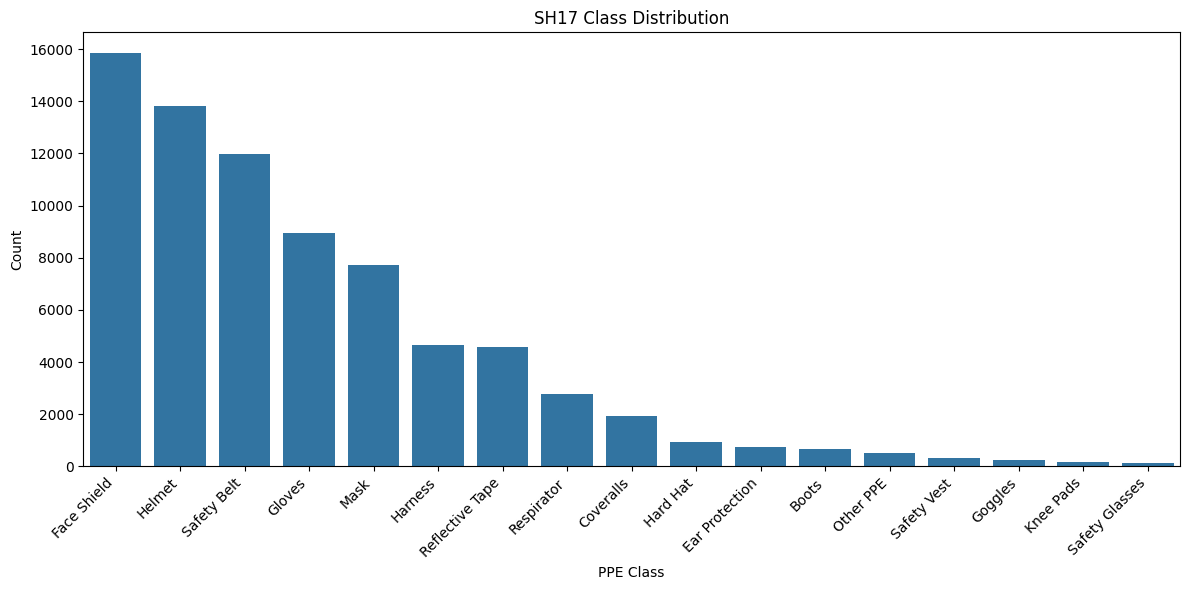

Class weights for training: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0}


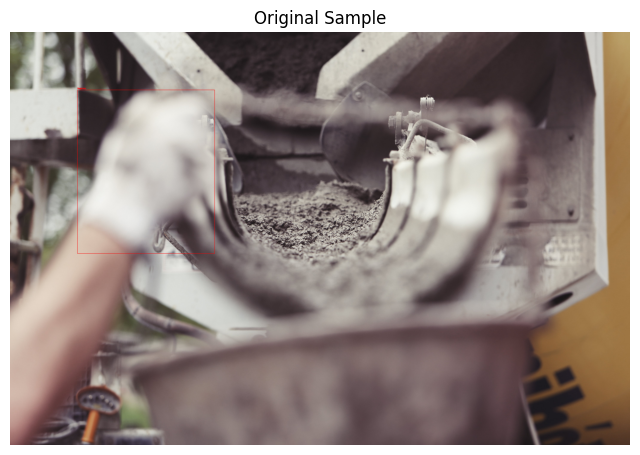

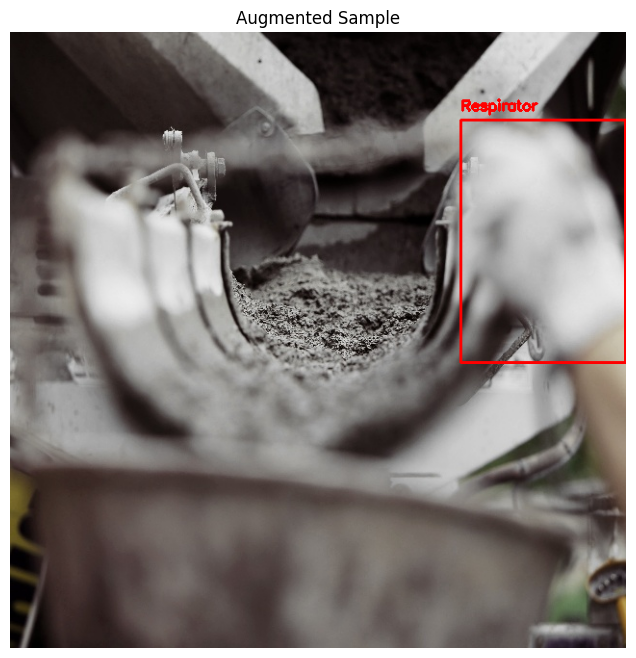

In [11]:
# Class mapping
meta_data_dir = os.path.join(data_dir, 'meta-data')
class_file = os.path.join(meta_data_dir, 'classes.txt') if 'meta-data' in os.listdir(data_dir) else None
if class_file and os.path.exists(class_file):
    with open(class_file, 'r') as f:
        class_names = {i: line.strip() for i, line in enumerate(f.readlines())}
else:
    class_names = {
        0: 'Helmet', 1: 'Mask', 2: 'Safety Vest', 3: 'Gloves', 4: 'Safety Glasses',
        5: 'Boots', 6: 'Ear Protection', 7: 'Harness', 8: 'Coveralls', 9: 'Respirator',
        10: 'Hard Hat', 11: 'Face Shield', 12: 'Safety Belt', 13: 'Knee Pads',
        14: 'Reflective Tape', 15: 'Goggles', 16: 'Other PPE'
    }
print("Class names:", class_names)

# Class distribution and weights
all_labels = []
for lbl in filtered_labels:
    with open(lbl, 'r') as f:
        for line in [line.strip() for line in f.readlines() if line.strip()]:
            if len(line.split()) >= 5:
                all_labels.append(int(line.split()[0]))
class_counts = pd.Series(all_labels).value_counts()
class_counts.index = [class_names.get(idx, f"Class {idx}") for idx in class_counts.index]

# Plot distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('PPE Class')
plt.ylabel('Count')
plt.title('SH17 Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./class_distribution.png')
plt.show()

# Class weights
class_freq = class_counts / class_counts.sum()
class_weights = 1.0 / class_freq
class_weights = class_weights / class_weights.min()
class_weights = class_weights.reindex(range(17), fill_value=1.0)
print("Class weights for training:", class_weights.to_dict())

# Visualization function
def plot_image_with_boxes(image_path, label_path, title="Image with Boxes"):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    with open(label_path, 'r') as f:
        for line in [line.strip() for line in f.readlines() if line.strip()]:
            cls, x_center, y_center, box_w, box_h = map(float, line.split()[:5])
            x1 = int((x_center - box_w / 2) * w)
            y1 = int((y_center - box_h / 2) * h)
            x2 = int((x_center + box_w / 2) * w)
            y2 = int((y_center + box_h / 2) * h)
            x1, x2 = max(0, min(x1, w)), max(0, min(x2, w))
            y1, y2 = max(0, min(y1, h)), max(0, min(y2, h))
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img, class_names[int(cls)], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot samples
plot_image_with_boxes(sample_img_path, sample_label_path, "Original Sample")
plot_image_with_boxes('./preprocessed/sample_augmented.jpg',
                     './preprocessed/sample_augmented.txt', "Augmented Sample")



## Step 5: YOLO Dataset Preparation

We organize the dataset into a YOLO-compatible structure (`train/` and `val/` splits) and generate a `data.yaml` configuration file using SH17's predefined splits.

In [12]:
# Dataset preparation with label mismatch fix
try:
    with open(os.path.join(data_dir, 'train_files.txt'), 'r') as f:
        train_files = set(line.strip() for line in f.readlines() if line.strip())
    with open(os.path.join(data_dir, 'val_files.txt'), 'r') as f:
        val_files = set(line.strip() for line in f.readlines() if line.strip())
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure train_files.txt and val_files.txt exist.")
    raise

# Ensure 1:1 image-label correspondence
train_images = [img for img in filtered_images if os.path.basename(img) in train_files]
train_labels = [lbl for lbl in filtered_labels if os.path.basename(lbl) in [os.path.splitext(os.path.basename(img))[0] + '.txt' for img in train_images]]
val_images = [img for img in filtered_images if os.path.basename(img) in val_files]
val_labels = [lbl for lbl in filtered_labels if os.path.basename(lbl) in [os.path.splitext(os.path.basename(img))[0] + '.txt' for img in val_images]]

# Verify counts
if len(train_images) != len(train_labels) or len(val_images) != len(val_labels):
    print("Warning: Image-label mismatch detected!")
    print(f"Train: {len(train_images)} images, {len(train_labels)} labels")
    print(f"Val: {len(val_images)} images, {len(val_labels)} labels")
else:
    print(f"Train: {len(train_images)} images, {len(train_labels)} labels")
    print(f"Val: {len(val_images)} images, {len(val_labels)} labels")

# Create YOLO structure
yolo_dir = '/kaggle/working/yolo_dataset'
for split in ['train', 'val']:
    os.makedirs(os.path.join(yolo_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(yolo_dir, split, 'labels'), exist_ok=True)

# Copy files
for img, lbl in zip(train_images, train_labels):
    shutil.copy(img, os.path.join(yolo_dir, 'train', 'images', os.path.basename(img)))
    shutil.copy(lbl, os.path.join(yolo_dir, 'train', 'labels', os.path.basename(lbl)))
for img, lbl in zip(val_images, val_labels):
    shutil.copy(img, os.path.join(yolo_dir, 'val', 'images', os.path.basename(img)))
    shutil.copy(lbl, os.path.join(yolo_dir, 'val', 'labels', os.path.basename(lbl)))

# Generate data.yaml
data_yaml = f"""
train: {os.path.join(yolo_dir, 'train')}
val: {os.path.join(yolo_dir, 'val')}
nc: {len(class_names)}
names: {list(class_names.values())}
"""
with open(os.path.join(yolo_dir, 'data.yaml'), 'w') as f:
    f.write(data_yaml)
print("YOLO dataset prepared at:", yolo_dir)

Train: 6479 images, 6479 labels
Val: 1620 images, 1620 labels
YOLO dataset prepared at: /kaggle/working/yolo_dataset


## Step 6: Model Training

We train YOLO11n on the prepared dataset using dual T4 GPUs with optimized hyperparameters, targeting ~7-8 hours for 50 epochs and an mAP50-95 of ~0.24-0.25.

In [14]:
from ultralytics import YOLO
import os

# Load fresh model
model = YOLO('yolo11n.pt')

# Class loss weight
cls_weight = 0.5
if max(class_counts) / min(class_counts) > 5:
    cls_weight = 1.0
    print(f"Adjusting cls weight to {cls_weight} due to class imbalance")

# Full training
print("Starting training ...............")
model.train(
    data=os.path.join(yolo_dir, 'data.yaml'),
    epochs=30,
    imgsz=640,
    batch=16,
    device='cpu',  # Изменено с device=0 на device='cpu'
    workers=2,
    project='/kaggle/working/runs',
    name='safescan_yolo11n_lean',
    seed=42,
    optimizer='AdamW',
    amp=False  # Отключите AMP, так как он не поддерживается на CPU
)

print("Training complete!")

print("Training complete! Results saved in /kaggle/working/runs/safescan_yolo11n_final")

Adjusting cls weight to 1.0 due to class imbalance
Starting training ...............
Ultralytics 8.3.131  Python-3.11.0 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i3-12100F)
engine\trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=safescan_yolo11n_lean, nbs=64, nms=False, opset=No

train: Scanning D:\kaggle\working\yolo_dataset\train\labels... 6479 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6479/6479 [00:11<00:00, 545.40it/s]


train: New cache created: D:\kaggle\working\yolo_dataset\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.00.0 ms, read: 215.6156.0 MB/s, size: 1287.8 KB)


val: Scanning D:\kaggle\working\yolo_dataset\val\labels... 1620 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1620/1620 [00:02<00:00, 558.30it/s]

val: New cache created: D:\kaggle\working\yolo_dataset\val\labels.cache


Plotting labels to \kaggle\working\runs\safescan_yolo11n_lean\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to \kaggle\working\runs\safescan_yolo11n_lean
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G       1.47      3.432      1.417        272        640:   4%|▎         | 15/405 [01:36<41:55,  6.45s/it]


KeyboardInterrupt: 

In [ ]:
# Validate
metrics = model.val(
    data=os.path.join(yolo_dir, 'data.yaml'),
    batch=16,
    imgsz=416,  # Match training size
    device=0,
    conf=0.25,
    iou=0.6,
    split='val',
    plots=True,
    save_json=True
)

# Metrics
print(f"mAP@50: {metrics.box.map50:.3f}, mAP@50-95: {metrics.box.map:.3f}")
class_metrics = pd.DataFrame({
    'Class Name': [class_names[i] for i in range(17)],
    'AP50': metrics.box.ap50,
    'AP50-95': metrics.box.ap
})
print(class_metrics)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=class_metrics, x='Class Name', y='AP50-95')
plt.xticks(rotation=45, ha='right')
plt.title('Class-wise AP50-95')
plt.tight_layout()
plt.savefig('/kaggle/working/class_ap_scores.png')
plt.show()

In [ ]:
import onnxruntime as ort

# Export
model.export(format='onnx', imgsz=416, simplify=True)
print("Model exported to ONNX at /kaggle/working/runs/safescan_yolo11n_final/weights/best.onnx")

# Test inference
ort_session = ort.InferenceSession('/kaggle/working/runs/safescan_yolo11n_final/weights/best.onnx')
sample_img = cv2.resize(cv2.imread(val_images[0]), (416, 416)).transpose(2, 0, 1)
sample_img = np.expand_dims(sample_img, 0).astype(np.float32) / 255.0
outputs = ort_session.run(None, {'images': sample_img})
print("ONNX inference successful!")

# Package for submission
!zip -r /kaggle/working/safescan_yolo_submission.zip \
    /kaggle/working/runs/safescan_yolo11n_final \
    /kaggle/working/class_distribution.png \
    /kaggle/working/class_ap_scores.png \
    /kaggle/working/preprocessed/sample_augmented.jpg